In [ ]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer

In [1]:
# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Import Parameter class
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from copy import deepcopy
from math import pi
import numpy as np

In [2]:
n = 2
qr = QuantumRegister(2+2*(n-1))
cr = ClassicalRegister(2+2*(n-1))

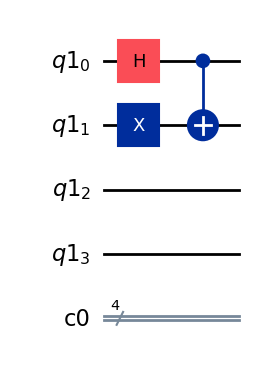

In [3]:
def source_new_circ(bitflip,round):
    source_new_circ = QuantumCircuit(qr,cr)
    source_new_circ.h(qr[2 * round])
    if bitflip:
        source_new_circ.x(qr[2 * round + 1])
    source_new_circ.cx(qr[2 * round],qr[2 * round + 1])
    return source_new_circ

source_new_circ(True,0).draw(output='mpl')
#source_new_circ(False).draw()

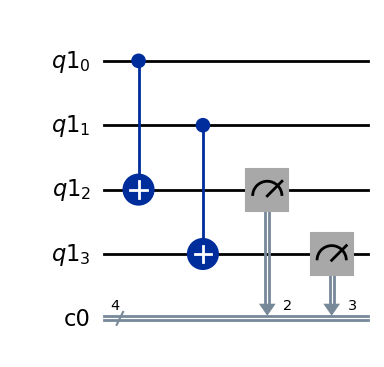

In [4]:
def purification_circ(round):
    purification_circ = QuantumCircuit(qr,cr)
    purification_circ.cx(qr[0], qr[2 * round])
    purification_circ.cx(qr[1], qr[2 * round + 1])

    purification_circ.measure(qr[2 * round], cr[2 * round])
    purification_circ.measure(qr[2 * round + 1], cr[2 * round + 1])

    return purification_circ

purification_circ(1).draw(output='mpl')

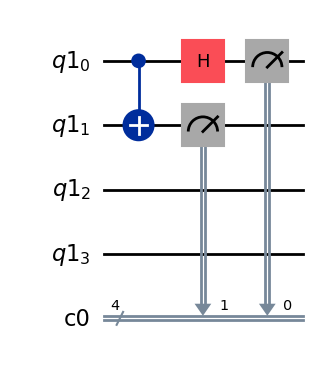

In [5]:
measurement_circ = QuantumCircuit(qr,cr)

measurement_circ.cx(qr[0], qr[1])
measurement_circ.h(qr[0])

measurement_circ.measure(qr[0], cr[0])
measurement_circ.measure(qr[1], cr[1])

measurement_circ.draw(output='mpl')

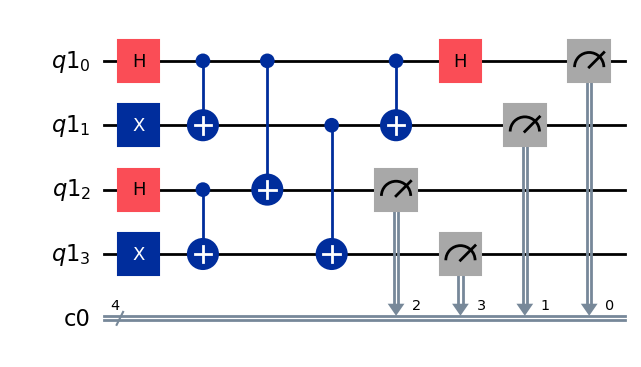

In [6]:
# Check.

experiment_circ = source_new_circ(True,0) & source_new_circ(True,1) & purification_circ(1) & measurement_circ

experiment_circ.draw(output='mpl')

In [7]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')
simulator = AerSimulator()

# generate a simulator that mimics the real quantum system with the latest calibration results
# backend = AerSimulator.from_backend(backend)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
options = {}

# Define Sampler
sampler = Sampler(mode=backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [ ]:
# Exact Sampler instead
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
pm = generate_preset_pass_manager(optimization_level=3)

In [8]:
import itertools
isa_circuits=[]
error_arrays = [list(i) for i in itertools.product([True, False],repeat=n)]

for error_array in error_arrays:
    experiment_circ = source_new_circ(error_array[0],0)
    for round in range(1,n):
      experiment_circ = experiment_circ & source_new_circ(error_array[round],round) & purification_circ(round)
    experiment_circ = experiment_circ & measurement_circ
    isa_circuits.append(pm.run(experiment_circ))

In [9]:
job = sampler.run(isa_circuits, shots=8192)
print(f"Job ID: {job.job_id()}")

Job ID: cxc6364tpsjg008x7ya0


In [12]:
results = service.job('cxc6364tpsjg008x7ya0').result()

In [13]:
from collections import Counter
z = Counter({})

for result in results:
  z += Counter(result.data.c0.get_counts())

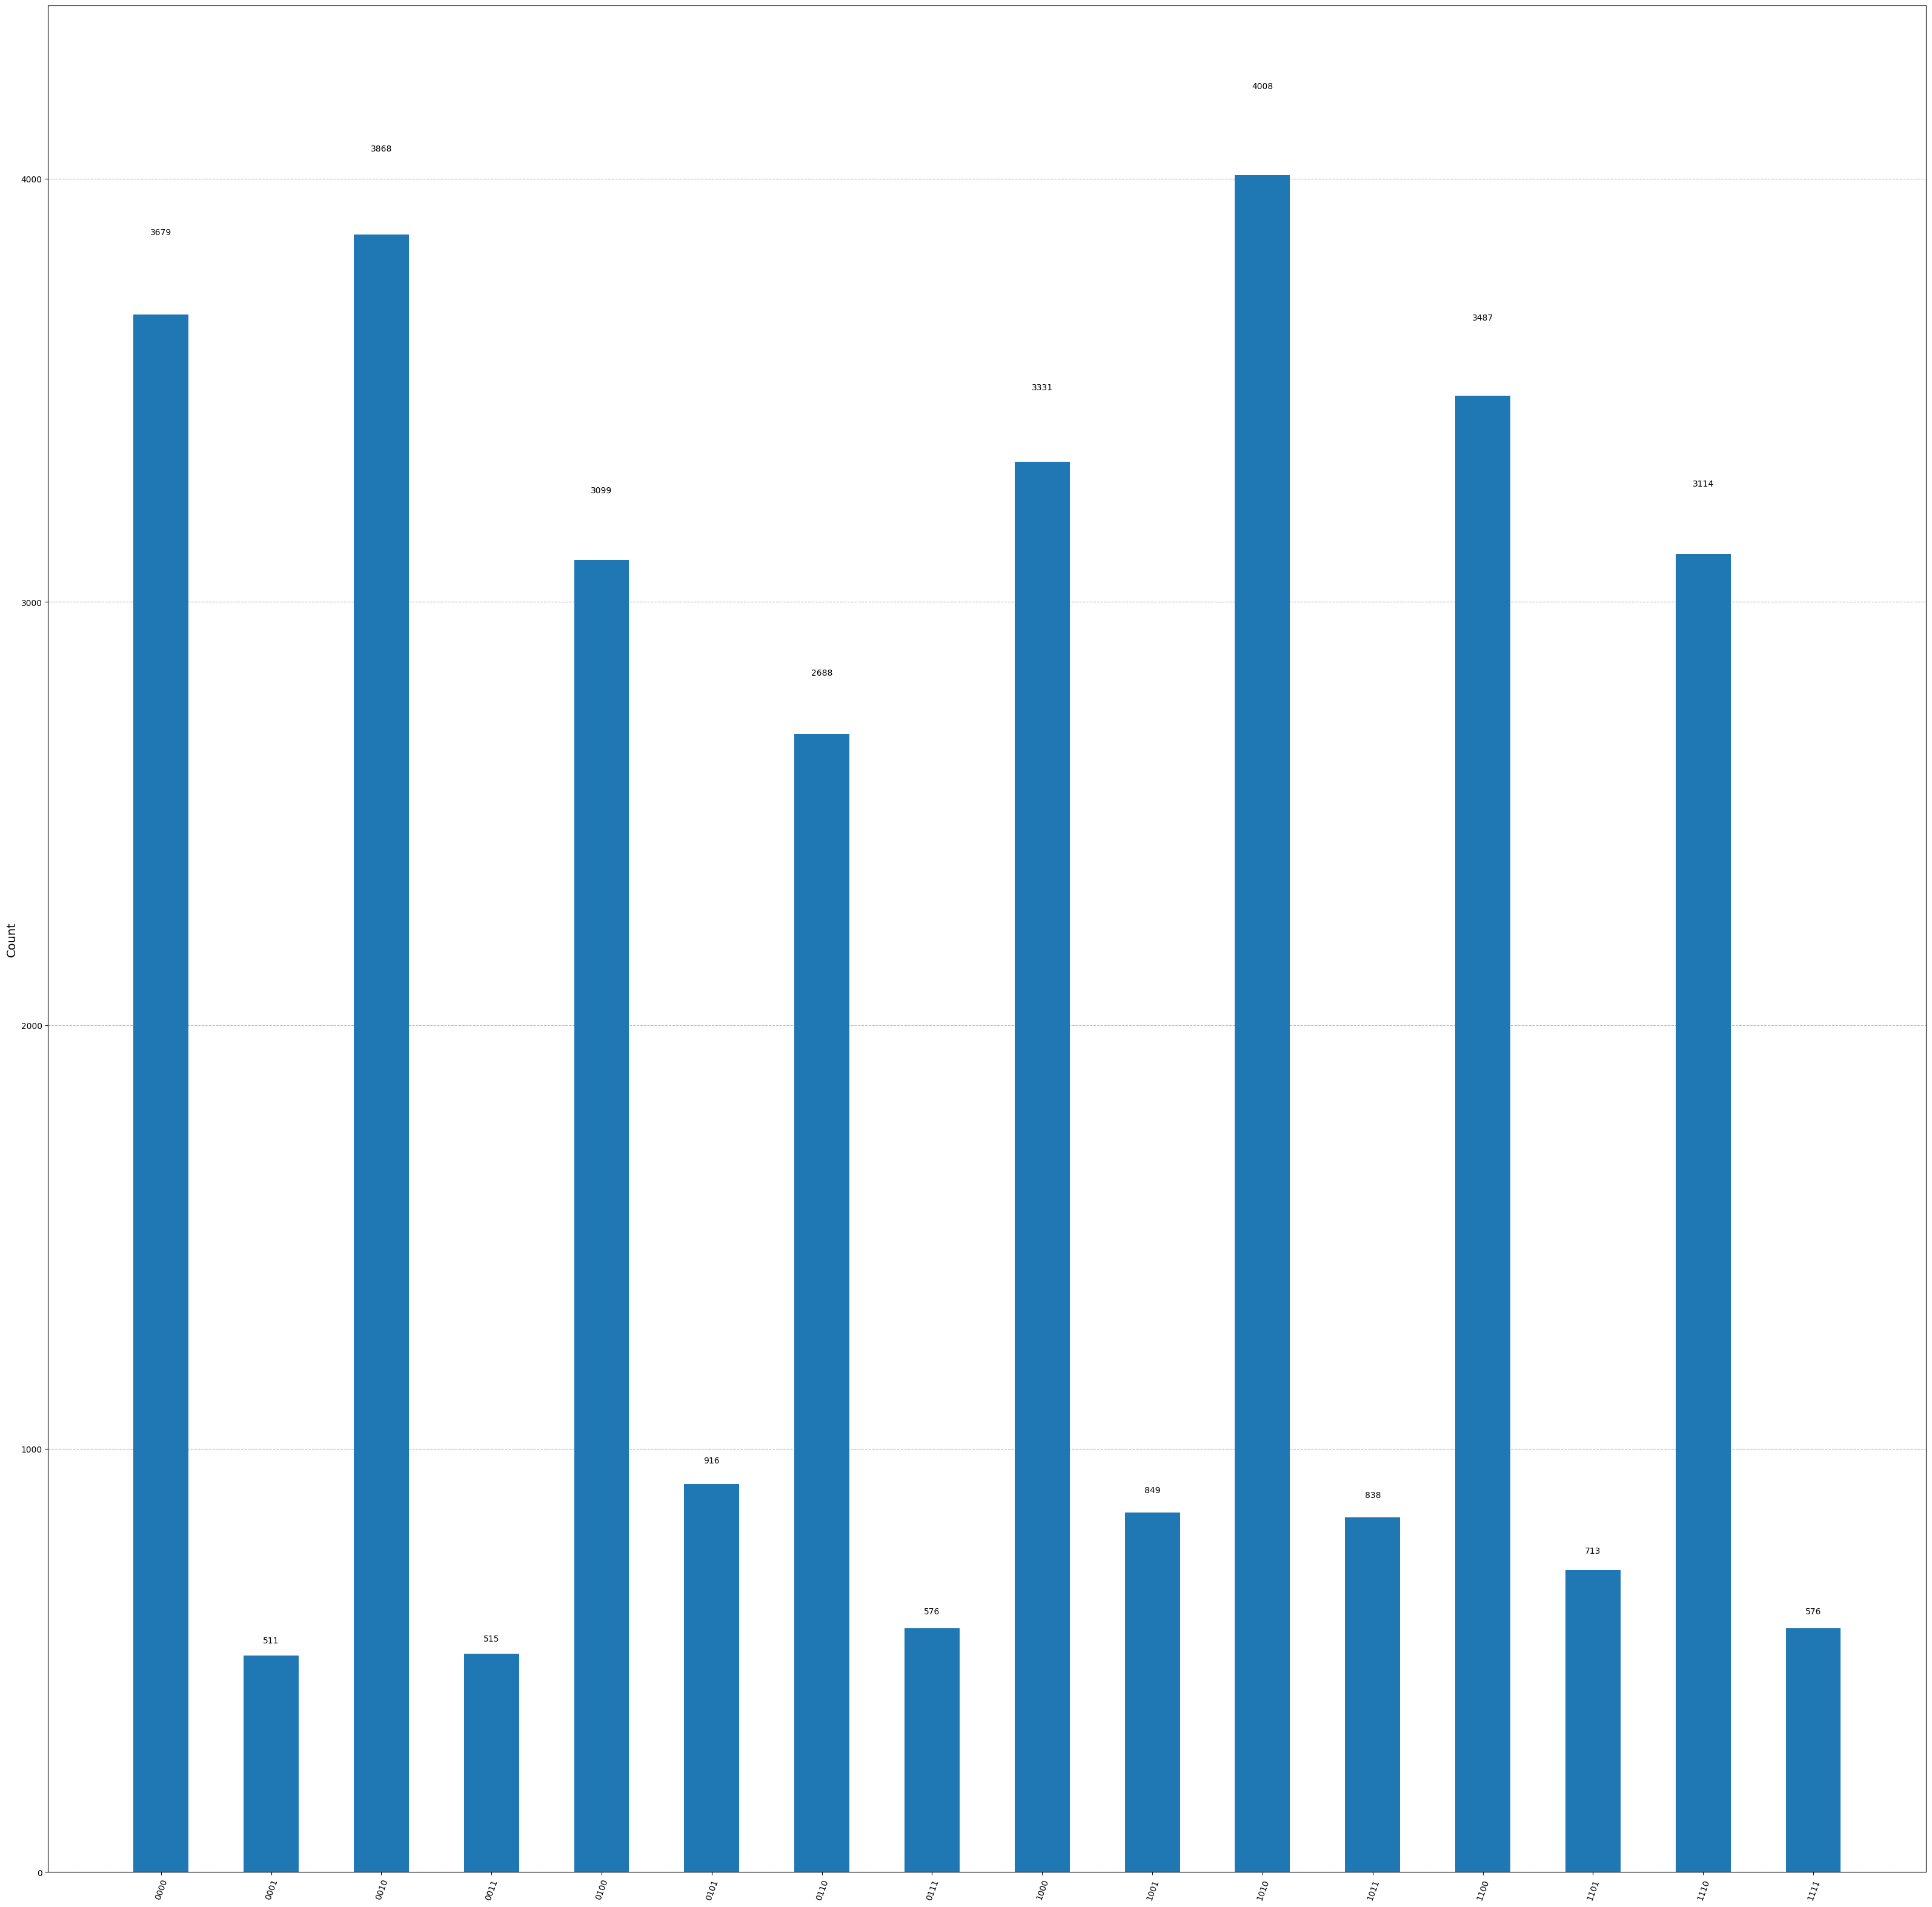

In [14]:
from qiskit.visualization import plot_histogram

plot_histogram(data=z, figsize=(40, 40))

In [18]:
(z['0000'] + z['1100']) / z.total()

0.21868896484375

In [16]:
z

Counter({'1010': 4008,
         '0010': 3868,
         '0000': 3679,
         '1100': 3487,
         '1000': 3331,
         '1110': 3114,
         '0100': 3099,
         '0110': 2688,
         '0101': 916,
         '1001': 849,
         '1011': 838,
         '1101': 713,
         '1111': 576,
         '0111': 576,
         '0011': 515,
         '0001': 511})